In [1]:
import pandas as pd 
from datetime import datetime
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec

# Données 
Les données récupérés le sont de bixi, (https://bixi.com/fr/donnees-ouvertes)[https://bixi.com/fr/donnees-ouvertes]
et de l'API Oikolab. 

In [2]:
deplacement = pd.read_csv('../transfo-data/2021-rawdata.csv')
deplacement

,start_date,emplacement_pk_start,end_date,emplacement_pk_end,duration_sec,is_member
0,2021-05-21 17:21:44.934,10,2021-05-21 18:07:58.699,10,2773,1
1,2021-06-12 14:45:02.959,10,2021-06-12 15:11:14.937,187,1571,0
2,2021-08-27 08:19:17.396,10,2021-08-27 08:29:04.477,506,587,1
3,2021-06-11 19:07:28.724,10,2021-06-11 19:50:30.214,10,2581,0
4,2021-05-25 07:19:29.669,10,2021-05-25 07:47:42.001,423,1692,1
...,...,...,...,...,...,...
5490038,2021-11-11 14:55:04.039,1140,2021-11-11 14:59:41.446,1140,277,0
5490039,2021-11-13 16:56:22.412,1140,2021-11-13 17:28:59.982,1140,1957,1
5490040,2021-11-11 18:41:06.111,1140,2021-11-11 18:48:18.115,928,432,1
5490041,2021-11-10 18:17:49.654,1140,2021-11-10 18:24:40.643,928,410,1


In [3]:
deplacement.start_date = deplacement.start_date.apply(lambda x: x.split(" ")[0])
deplacement_par_jour = deplacement.groupby("start_date").count()
deplacement_par_jour.sort_values(by=["start_date"], inplace=True)
deplacement_par_jour.drop(deplacement_par_jour.columns.difference(["start_date","emplacement_pk_start"]),1,inplace=True)
deplacement_par_jour.reset_index(inplace=True)
deplacement_par_jour.rename({"emplacement_pk_start":"nb"},inplace=True,errors="raise",axis="columns")

/tmp/ipykernel_38642/691118772.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  deplacement_par_jour.drop(deplacement_par_jour.columns.difference(["start_date","emplacement_pk_start"]),1,inplace=True)


In [4]:
date_debut, date_fin= deplacement_par_jour['start_date'][0],deplacement_par_jour['start_date'][len(deplacement_par_jour)-1]
date_debut, date_fin
import requests

r = requests.get('https://api.oikolab.com/weather',
                 params={'param': ['temperature','wind_speed','total_precipitation'],
                         'start': date_debut,
                         'end': date_fin,
                         'lat': 43.6529,
                         'lon': -79.3849,
                         'freq':'D',
                         'api-key': '9bcc801713754ea5afb3a7aad60e263f'}
                 )
#svp ne pas réutiliser l'apikey qui est la mienne
import json
import pandas as pd

weather_data = json.loads(r.json()['data'])
df = pd.DataFrame(index=pd.to_datetime(weather_data['index'],
                                       unit='s'),
                  data=weather_data['data'],
                  columns=weather_data['columns'])

In [5]:
df2 = df.drop(columns=["model (name)", "coordinates (lat,lon)","utc_offset (hrs)","model elevation (surface)"])
df2.rename({"temperature (degC)":"temp", "wind_speed (m/s)":"wind", "total_precipitation (mm of water equivalent)":"rain"},errors="raise",axis='columns',inplace=True)
df2.index.name = "date"
df2.reset_index(inplace=True)
df2.head()

,date,temp,wind,rain
0,2021-04-09,10.68,4.25,0.11
1,2021-04-10,10.12,3.52,0.00
2,2021-04-11,9.83,4.33,0.92
3,2021-04-12,7.28,4.47,0.27
4,2021-04-13,6.45,2.21,0.01


In [6]:
deplacement_par_jour["start_date"] = pd.to_datetime(deplacement_par_jour["start_date"])
df = deplacement_par_jour.merge(df2, left_on="start_date", right_on="date")
df.drop(columns="start_date",inplace=True)
df['Dayweek'] = df['date'].dt.day_name()
df["Month"]=df["date"].dt.month
df.head(),df.tail()

(      nb       date   temp  wind  rain   Dayweek  Month
 0   8255 2021-04-09  10.68  4.25  0.11    Friday      4
 1  16889 2021-04-10  10.12  3.52  0.00  Saturday      4
 2  13475 2021-04-11   9.83  4.33  0.92    Sunday      4
 3   9508 2021-04-12   7.28  4.47  0.27    Monday      4
 4  13433 2021-04-13   6.45  2.21  0.01   Tuesday      4,
         nb       date   temp  wind  rain   Dayweek  Month
 216  20620 2021-11-11   9.23  5.79  0.04  Thursday     11
 217  11907 2021-11-12  11.15  6.18  0.19    Friday     11
 218  12095 2021-11-13   6.16  6.12  0.05  Saturday     11
 219  13543 2021-11-14   4.15  6.21  0.21    Sunday     11
 220  10064 2021-11-15   2.83  4.00  0.72    Monday     11)

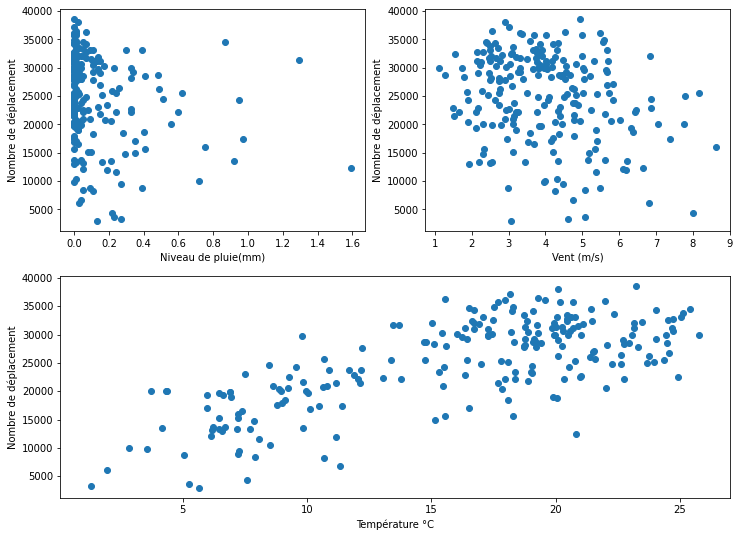

In [7]:
gs = gridspec.GridSpec(2, 2)
plt.figure(figsize=(12,9))

plt.subplot(gs[0, 0])
data = {"nb" : df["nb"],
        "rain": df["rain"]}
plt.xlabel("Niveau de pluie(mm)")
plt.ylabel("Nombre de déplacement")
plt.scatter("rain","nb",data=df)

plt.subplot(gs[1, :])
data = {"nb" : df["nb"],
        "temp": df["temp"]}
plt.xlabel("Température °C")
plt.ylabel("Nombre de déplacement")
plt.scatter("temp","nb",data=df)

plt.subplot(gs[0, 1])
data = {"nb" : df["nb"],
        "wind": df["wind"]}
plt.xlabel("Vent (m/s)")
plt.ylabel("Nombre de déplacement")
plt.scatter("wind","nb",data=data)


In [8]:
df_month=df.groupby(["Month"]).mean()
df_month.reset_index(inplace=True)

<BarContainer object of 8 artists>

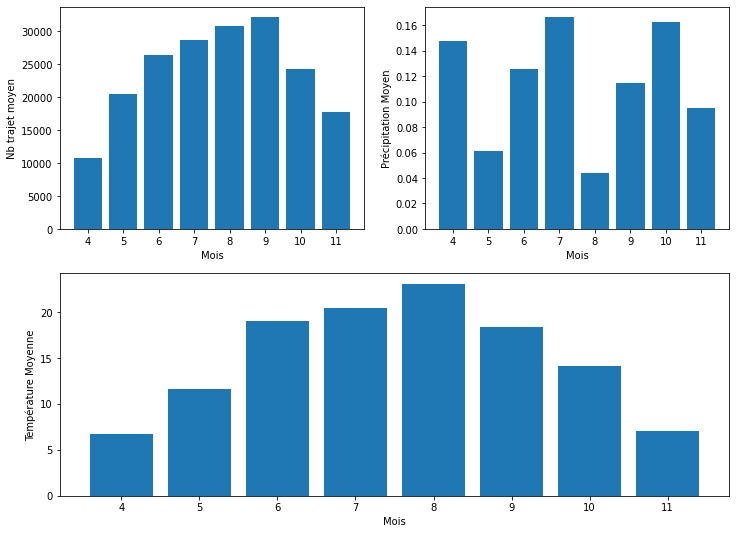

In [9]:
gs = gridspec.GridSpec(2, 2)

plt.figure(figsize=(12,9))
plt.subplot(gs[0, 0])
plt.ylabel("Nb trajet moyen")
plt.xlabel("Mois")
plt.bar(x='Month',height="nb",data=df_month)

plt.subplot(gs[0, 1])
plt.ylabel("Précipitation Moyen")
plt.xlabel("Mois")
plt.bar(x='Month',height="rain",data=df_month)

plt.subplot(gs[1, :])
plt.ylabel("Température Moyenne")
plt.xlabel("Mois")
plt.bar(x='Month',height="temp",data=df_month)

On peux émettre une première hypothèse que le nombre de déplacement est fortement corrélés à la pluie et à la température mais aussi à la température.

In [10]:
df.to_csv('../data/meteo_2021.csv',index=False)